Processing images for /home/workstation/code/XAImethods/CAIN/results/imagenet/val_images10k_vit/google/vit-large-patch32-384/GradCAM: 100%|██████████| 5065/5065 [00:37<00:00, 133.66it/s]
Processing images for /home/workstation/code/XAImethods/CAIN/results/imagenet/val_images10k_vit/google/vit-large-patch32-384/GradCAMPlusPlus: 100%|██████████| 5065/5065 [00:37<00:00, 135.49it/s]
Processing images for /home/workstation/code/XAImethods/CAIN/results/imagenet/val_images10k_vit/google/vit-large-patch32-384/HiResCAM: 100%|██████████| 5065/5065 [00:35<00:00, 141.30it/s]
Processing images for /home/workstation/code/XAImethods/CAIN/results/imagenet/val_images10k_vit/google/vit-large-patch32-384/LayerCAM: 100%|██████████| 5065/5065 [00:39<00:00, 129.76it/s]
Processing images for /home/workstation/code/XAImethods/CAIN/results/imagenet/val_images10k_vit/google/vit-large-patch32-384/XGradCAM: 100%|██████████| 5065/5065 [00:38<00:00, 131.24it/s]


NameError: name 'CAM_ALGORITHMS' is not defined

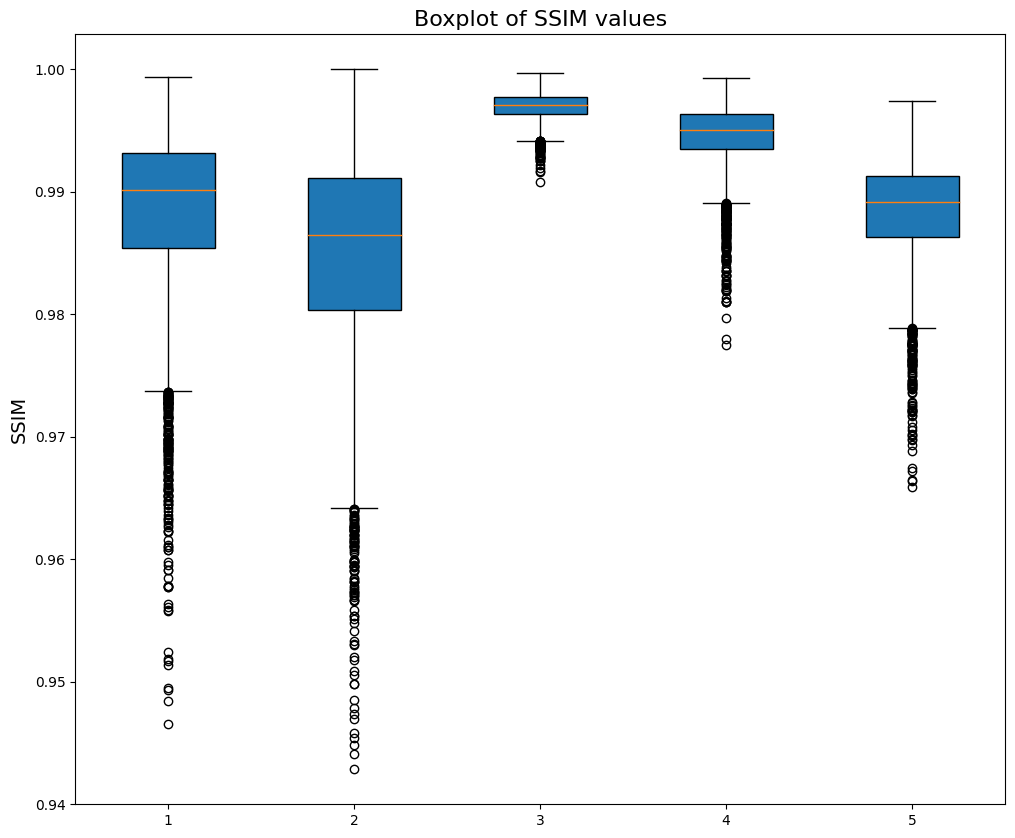

In [6]:
import numpy as np
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
from skimage.metrics import structural_similarity as compare_ssim

def load_subdirs(dataset_path):
    dataset_path = Path(dataset_path)
    subdirs = [subdir for subdir in dataset_path.iterdir() if subdir.is_dir()]
    subdir_names = [subdir.name for subdir in subdirs]
    return subdir_names, subdirs

def binarize(image, threshold=0.5):
    """Binarize an image based on a threshold."""
    binary_image = (image > threshold).astype(int)
    return binary_image

def area_ratio(image1, image2):
    """Compute the area ratio of two binarized images."""
    area1 = np.sum(image1)
    area2 = np.sum(image2)
    if area1 == 0:
        return float('inf') if area2 != 0 else 1.0
    return area2 / area1

def compute_ssim(image1, image2):
    """Compute the SSIM between two images."""
    return compare_ssim(image1, image2, data_range=1.0 if image1.dtype == np.float64 else 255)

def process_pair_ssim(results_images_path, results_attack_images_path):
    _, subdirs1 = load_subdirs(results_images_path)
    _, subdirs2 = load_subdirs(results_attack_images_path)

    file_names_path2 = [subdir.name for subdir in subdirs2]
    ssim_values = []

    for file_name in tqdm(file_names_path2, desc=f"Processing images for {results_images_path}"):
        subdir2 = Path(results_attack_images_path) / file_name
        subdir1 = Path(results_images_path) / file_name
        
        if not subdir1.exists():
            continue
        
        grayscale_path1 = subdir1 / "grayscale.npy" if (subdir1 / "grayscale.npy").exists() else subdir1 / "grayscale.jpg"
        grayscale_path2 = subdir2 / "grayscale.npy" if (subdir2 / "grayscale.npy").exists() else subdir2 / "grayscale.jpg"
        
        if grayscale_path1.suffix == ".npy":
            grayscale1 = np.load(grayscale_path1)
        else:
            grayscale1 = np.array(Image.open(grayscale_path1))
            
        if grayscale_path2.suffix == ".npy":
            grayscale2 = np.load(grayscale_path2)
        else:
            grayscale2 = np.array(Image.open(grayscale_path2))
        
        ssim_value = compute_ssim(grayscale1, grayscale2)
        ssim_values.append(ssim_value)
    return ssim_values


image_paths = [
    ("/home/workstation/code/XAImethods/CAIN/results/imagenet/val_images10k_vit/google/vit-large-patch32-384/GradCAM", "/home/workstation/code/XAImethods/CAIN/results/imagenet/val_images10k_attack/defocus_blur/3_vit/google/vit-large-patch32-384/GradCAM"),
    ("/home/workstation/code/XAImethods/CAIN/results/imagenet/val_images10k_vit/google/vit-large-patch32-384/GradCAMPlusPlus", "/home/workstation/code/XAImethods/CAIN/results/imagenet/val_images10k_attack/defocus_blur/3_vit/google/vit-large-patch32-384/GradCAMPlusPlus"),
    ("/home/workstation/code/XAImethods/CAIN/results/imagenet/val_images10k_vit/google/vit-large-patch32-384/HiResCAM", "/home/workstation/code/XAImethods/CAIN/results/imagenet/val_images10k_attack/defocus_blur/3_vit/google/vit-large-patch32-384/HiResCAM"),
    ("/home/workstation/code/XAImethods/CAIN/results/imagenet/val_images10k_vit/google/vit-large-patch32-384/LayerCAM", "/home/workstation/code/XAImethods/CAIN/results/imagenet/val_images10k_attack/defocus_blur/3_vit/google/vit-large-patch32-384/LayerCAM"),
    ("/home/workstation/code/XAImethods/CAIN/results/imagenet/val_images10k_vit/google/vit-large-patch32-384/XGradCAM", "/home/workstation/code/XAImethods/CAIN/results/imagenet/val_images10k_attack/defocus_blur/3_vit/google/vit-large-patch32-384/XGradCAM"),
]


all_ssim_values = []

for img_path, attack_path in image_paths:
    ssims = process_pair_ssim(img_path, attack_path)
    all_ssim_values.append(ssims)
CAM_ALGORITHMS = ["GradCAM", "GradCAMPlusPlus", "HiResCAM",  "LayerCAM", "XGradCAM"]
# Plotting
plt.figure(figsize=(12, 10))
plt.violinplot(all_ssim_values, showmeans=True, showmedians=True, showextrema=True)
plt.title("Violin plot of SSIM values", fontsize=16)
plt.ylabel("SSIM", fontsize=14)

# Setting the y-axis limits and reversing them
plt.ylim(0.9,1)  # Set the y-axis limits
plt.gca().invert_yaxis()  # Reverse the y-axis

# Use the CAM_ALGORITHMS names for the x-axis labels
plt.xticks(np.arange(1, len(CAM_ALGORITHMS) + 1), CAM_ALGORITHMS, fontsize=12, rotation=45)

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig("violinplot_ssim_values.png", dpi=300)
plt.show()
